In [17]:
using CSV, DataFrames, Statistics, Random, Plots, JuMP, Gurobi, Distributions, Random, Metrics
using StatsBase: sample

#import sklearn functions 
using ScikitLearn
@sk_import linear_model: LogisticRegression
@sk_import linear_model: LinearRegression
@sk_import linear_model: Lasso
@sk_import metrics:accuracy_score;
@sk_import metrics:precision_score;
@sk_import metrics:recall_score;
@sk_import metrics:mean_squared_error;

include("utils.jl");

In [2]:
#todo change X_shifted that it is added later
mutable struct RegressionClass
    name::String
    X_full::DataFrame
    X_shifted::DataFrame
    y_full::Vector{Float64}
    y_shifted::Vector{Float64}
    covar_dist_type::String
    covar_parameters::Vector{Any}
    lambas_range::Vector{Float64}
    train_test_prop::Float64
    train_val_prop::Float64
    num_runs::Float64
end

### preprocess functions

In [5]:
# function generate_covariate_shift(rc::RegressionClass, seed = 123)
#     #set a seed for distribution
#     Random.seed!(seed)

#     if rc.covar_dist_type == "Normal"
#         col_means = mean(Matrix(rc.X), dims=1)
#         col_vars = var(Matrix(rc.X), dims = 1)

#         random_values = zeros(size(rc.X))

#         for col_index in 1:size(rc.X, 2)
#             col_mean = col_means[col_index]
#             col_var = col_vars[col_index]
#             col_shift = rand(Normal(col_mean + rc.covar_parameters[1] , sqrt(col_var) * rc.covar_parameters[2]), (size(rc.X, 1), 1))
#             random_values[:, col_index] = col_shift
#         end

#         X_shifted = Matrix(rc.X) .+ random_values;
#         rc.X_shifted = DataFrame(X_shifted, Symbol.(names(rc.X)))
#     end
# end

In [4]:
function train_test_split(rc::RegressionClass, random_seed)
    
    Random.seed!(random_seed)

    num_indices = round(Int, rc.train_test_prop * length(rc.y_full))
    train_indices = sample(1:length(rc.y_full), num_indices, replace=false)
    test_indices = setdiff(1:length(rc.y_full), train_indices)
    
    X_train, y_train = Matrix(rc.X_full)[train_indices, :], rc.y_full[train_indices]
    X_test, y_test = Matrix(rc.X_shifted)[test_indices, :], rc.y_shifted[test_indices]
    
    return (X_train, y_train), (X_test, y_test)
end

train_test_split (generic function with 1 method)

### Stable Regression

In [5]:
function train_val_opt_split(rc::RegressionClass, X_train_full, y_train_full, beta_opt, weights = "nothing")

    residuals = y_train_full - X_train_full * beta_opt

    if weights == "nothing"
        sorted_indices = sortperm(abs.(residuals), rev=true)
    else 
        residuals_weights = [residuals[i] * weights[i] for i in 1:length(weights)]
        sorted_indices = sortperm(abs.(residuals_weights), rev=true)
    end

    num_train_points = round(Int, rc.train_val_prop * length(sorted_indices))

    train_indices = sorted_indices[1:num_train_points]

    val_indices = setdiff(1:length(y_train_full), train_indices)

    X_train = X_train_full[train_indices, :] 
    y_train = y_train_full[train_indices]

    X_val = X_train_full[val_indices, :]
    y_val = y_train_full[val_indices]

    return X_train, y_train, X_val, y_val
end


train_val_opt_split (generic function with 2 methods)

In [6]:
#todo: could change X, y to X_train, y_train
function get_optimized_split(rc::RegressionClass, X, y, lambda, weights="nothing")
    # to do: should n be an attribute
    n, p = size(X)
    k = round(Int, n * rc.train_val_prop)
    
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, theta)
    @variable(model, u[1:n] >= 0)
    @variable(model, beta[1:p])
    @variable(model, w[1:p])
    @objective(model, Min, k * theta + sum(u) + lambda * sum(w))
    
    for i in 1:p
        @constraint(model, w[i] >= beta[i])
        @constraint(model, w[i] >= -beta[i])
    end 
    
    for i in 1:n
        if weights == "nothing"
            @constraint(model, theta + u[i] >= y[i] - sum(X[i, :].*beta))
            @constraint(model, theta + u[i] >= -(y[i] - sum(X[i, :].*beta)))
        else 
            @constraint(model, theta + u[i] >=  weights[i] * (y[i] - sum(X[i, :].*beta)))
            @constraint(model, theta + u[i] >= - weights[i] * (y[i] - sum(X[i, :].*beta)))
        end 
    end
    
    
    optimize!(model)
    return value(theta), value.(u), value.(beta), value.(w) 
end

get_optimized_split (generic function with 2 methods)

In [7]:
function get_optimized_split_test_score(rc::RegressionClass, X_full_train, y_full_train, X_test, y_test, weights="nothing", print_result=false)
    best_lambda = Inf
    best_val_mse = Inf
    best_model = Inf
    
    for lambda in rc.lambas_range
        # Get optimized split
        _, _, betas, _ = get_optimized_split(rc, X_full_train, y_full_train, lambda, weights)
        X_train, y_train, X_val, y_val = train_val_opt_split(rc, X_full_train, y_full_train, betas, weights)
        
        # Predict on validation set
        y_pred_val =  X_val * betas
        val_mse_i = mse(y_val, y_pred_val)
        
        if best_val_mse > val_mse_i
            best_lambda = lambda
            best_val_mse = val_mse_i
            best_model = betas
        end
    end

    #get mse on test set for best performing model 
    y_pred_test = X_test * best_model
    mse_test_mse = mse(y_test, y_pred_test)

    if print_result
        println("Best lambda: ", best_lambda)
        println("Validation score: ", best_val_mse)
        println("Test score: ", mse_test_mse)
        println("Number of betas: ", length(best_model))
    end

    return best_model, mse_test_mse
end

get_optimized_split_test_score (generic function with 3 methods)

In [8]:
function get_random_test_score(rc::RegressionClass, X_full_train, y_full_train, X_test, y_test, seed_value, weights="nothing", print_result=false)
    best_lambda = Inf
    best_val_mse = Inf
    best_model = Inf

    (X_train, y_train), (X_val, y_val) = 
        IAI.split_data(:regression, X_full_train, y_full_train, train_proportion=rc.train_val_prop, seed=seed_value)

    for lambda in rc.lambas_range
        beta_star = LassoRegression(X_train, y_train, lambda, weights)

        y_pred_val = X_val * beta_star
        val_mse_i = mse(y_val, y_pred_val)

        if best_val_mse > val_mse_i
            best_lambda = lambda
            best_val_mse = val_mse_i
            best_model = beta_star
        end
    end

    #get test mse score on best performing model
    y_pred_test = X_test * best_model
    mse_test_mse = mse(y_test, y_pred_test)

    if print_result
        println("Best lambda: ", best_lambda)
        println("Validation score: ", best_val_mse)
        println("Test score: ", mse_test_mse)
        println("Number of betas: ", length(best_model))
    end
   
    return best_model, mse_test_mse
end


get_random_test_score (generic function with 3 methods)

In [9]:
#todo: deal with prints (false)
#todo: add what is returned to instance 
function repeat_four_methods(rc::RegressionClass)

    random_mse_test_scores, random_weights_mse_test_scores = [], []
    optim_mse_test_scores, optim_weights_mse_test_scores = [], []

    rand_betas, rand_weights_betas = [], []
    opt_betas, opt_weights_betas = [], []

    for random_seed in 1:rc.num_runs
        random_seed = Int(random_seed) #need to be int 

        if rc.covar_dist_type == "PCA"
            #pca shift on real dataset 
            (X_train, y_train), (X_test, y_test) = generate_covariate_shift_PCA(rc, random_seed)
        else
            # synthetic data (shift has already been performed when creating the dataset)
            (X_train, y_train), (X_test, y_test) = train_test_split(rc, random_seed)
        end
        
        X_train_norm, X_test_norm = normalize_data(X_train, X_test)
        X_train_norm, X_test_norm = add_intercept(X_train_norm), add_intercept(X_test_norm)

        weights = get_weights(X_train_norm, X_test_norm, false)

        if random_seed % 10 == 0
            println(random_seed)
        end

        # println("Starting Randomization")
        rand_beta, random_mse_test_score = get_random_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, 209, "nothing", false)
        push!(random_mse_test_scores, random_mse_test_score)
        push!(rand_betas, rand_beta)
        
        
        # println("Starting Randomization with covariate weights")
        rand_weights_beta, random_weights_mse_test_score = get_random_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, 209, weights, false)
        push!(random_weights_mse_test_scores, random_weights_mse_test_score)
        push!(rand_weights_betas, rand_weights_beta)
        
        # println("Starting Optimization")
        opt_beta, optim_mse_test_score = get_optimized_split_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, "nothing", false)
        push!(optim_mse_test_scores, optim_mse_test_score)
        push!(opt_betas, opt_beta)

        
        # println("Starting Optimization with covariate weights")
        opt_weights_beta, optim_weights_mse_test_score = get_optimized_split_test_score(rc, X_train_norm, y_train, X_test_norm, y_test, weights, false)
        push!(optim_weights_mse_test_scores, optim_weights_mse_test_score)
        push!(opt_weights_betas, opt_weights_beta)
    end 
    
    return (rand_betas, rand_weights_betas, opt_betas, opt_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores)
end


repeat_four_methods (generic function with 1 method)

## Test with DATA


In [10]:
#hyperparameters
num_runs = 100
train_test_prop = 0.9
train_val_prop = 0.7
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1];

### Test with synthetic data

- https://jmlr.org/papers/volume8/sugiyama07a/sugiyama07a.pdf

- page 7

In [103]:
(X_full, y_full), (X_shifted, y_shifted) = generate_synthetic_data(500, "1", 123)

synthetic_instance_1 = RegressionClass(
    "synthetic_1",
    X_full,
    X_shifted,
    y_full,
    y_shifted,
    "Synthetic",
    [0,0],
    lambdas,
    train_test_prop,
    train_val_prop,
    1000);

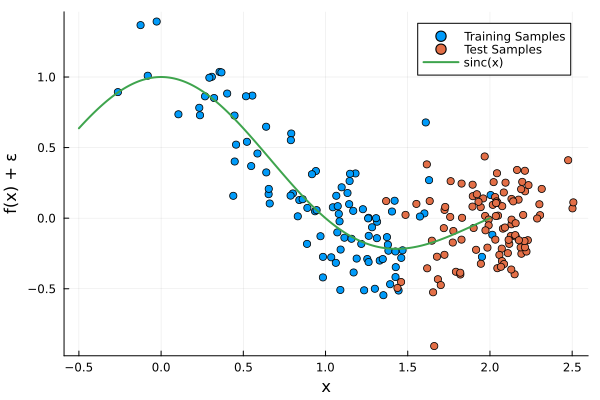

In [104]:
plot_synthetic(X_full, y_full, X_shifted, y_shifted, "1")

In [143]:
(rand_betas, rand_weights_betas, opt_betas, opt_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores) = repeat_four_methods(synthetic_instance_1);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11

In [128]:
improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

println("% improvement in mse with no weight: ", improv_no_weight)
println("% improvement in mse with weight: ", improv_with_weight)

% improvement in mse with no weight: 0.18941473969783473
% improvement in mse with weight: 76.40626893552299


In [ ]:
mean_random_betas = mean(rand_betas, dims = 1)
mean_random_weights_betas = mean(rand_weights_betas, dims = 1)
mean_opt_betas = mean(opt_betas, dims = 1)
mean_opt_weights_betas = mean(opt_weights_betas, dims = 1);

In [ ]:
f_1(x) = sinc(x)
f_ow(x) =  mean_opt_weights_betas[1] +  mean_opt_weights_betas[2]* x
f_rw(x) =  mean_random_weights_betas[1] +  mean_random_weights_betas[2]* x
f_r(x) =  mean_random_betas[1] +  mean_random_betas[2]* x
f_o(x) =  mean_opt_betas[1] +  mean_opt_betas[2]* x

plot_obj = scatter(Matrix(X_full), y_full, label="Training Samples", xlabel="x", ylabel="f(x) + ε")
scatter!(Matrix(X_shifted), y_shifted, label="Test Samples")

x_values = range(-0.5, stop=2, length=500)
plot!(x_values, f_1.(x_values), label="sinc(x)", linewidth=2, size=(800, 600))
plot!(x_values, f_ow.(x_values), label="opt with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_rw.(x_values), label="rand with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_r.(x_values), label="rand no weights", linewidth=2, size=(800, 600))
plot!(x_values, f_o.(x_values), label="opt no weights", linewidth=2, size=(800, 600))

savefig(plot_obj, "../data/imgs/covariate_shift_synthetic_data_1.png")

display(plot_obj)

### synthetic data 2

In [55]:
(X_full, y_full), (X_shifted, y_shifted) = generate_synthetic_data(500, "2", 123)

synthetic_instance_2 = RegressionClass(
    "synthetic_2",
    X_full,
    X_shifted,
    y_full,
    y_shifted,
    "Synthetic",
    [0,0],
    lambdas,
    train_test_prop,
    train_val_prop,
    1000);

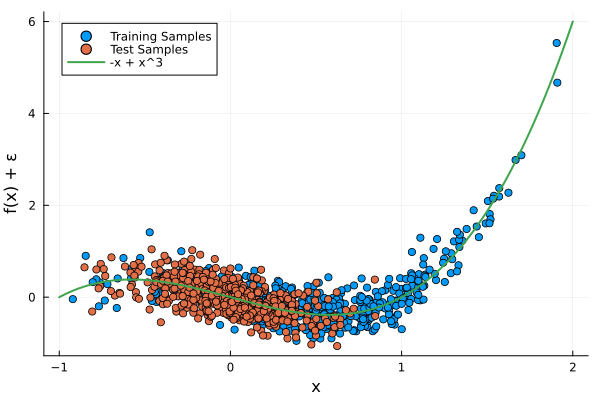

In [56]:
plot_synthetic(X_full, y_full, X_shifted, y_shifted, "2")

In [57]:
(rand_betas, rand_weights_betas, opt_betas, opt_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores, optim_mse_test_scores, optim_weights_mse_test_scores) = repeat_four_methods(synthetic_instance_2);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11

Excessive output truncated after 526087 bytes.

In [58]:
improv_no_weight = calculate_percentage_improvement(optim_mse_test_scores, random_mse_test_scores)
improv_with_weight = calculate_percentage_improvement(optim_weights_mse_test_scores, random_weights_mse_test_scores)

println("% improvement in mse with no weight: ", improv_no_weight)
println("% improvement in mse with weight: ", improv_with_weight)

% improvement in mse with no weight: -2.171652386755537
% improvement in mse with weight: 30.791505676240444


In [59]:
mean_random_betas = mean(rand_betas, dims = 1)
mean_random_weights_betas = mean(rand_weights_betas, dims = 1)
mean_opt_betas = mean(opt_betas, dims = 1)
mean_opt_weights_betas = mean(opt_weights_betas, dims = 1);

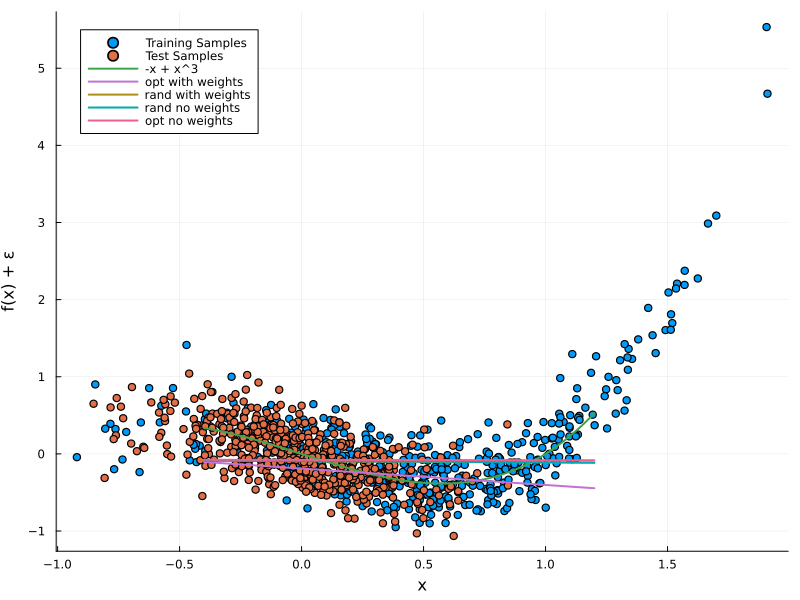

In [61]:
f_2(x) = -x + x^3 
f_ow(x) =  mean_opt_weights_betas[1][1] +  mean_opt_weights_betas[1][2]* x
f_rw(x) =  mean_random_weights_betas[1][1] +  mean_random_weights_betas[1][2]* x
f_r(x) =  mean_random_betas[1][1] +  mean_random_betas[1][2]* x
f_o(x) =  mean_opt_betas[1][1] +  mean_opt_betas[1][2]* x


plot_obj = scatter(Matrix(X_full), y_full, label="Training Samples", xlabel="x", ylabel="f(x) + ε")
scatter!(Matrix(X_shifted), y_shifted, label="Test Samples")

x_values = range(-0.4, stop=1.2, length=500)

# Modify the size attribute to make the plot bigger
plot!(x_values, f_2.(x_values), label="-x + x^3", linewidth=2, size=(800, 600))
plot!(x_values, f_ow.(x_values), label="opt with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_rw.(x_values), label="rand with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_r.(x_values), label="rand no weights", linewidth=2, size=(800, 600))
plot!(x_values, f_o.(x_values), label="opt no weights", linewidth=2, size=(800, 600))

savefig(plot_obj, "../data/imgs/covariate_shift_synthetic_data_2.png")

display(plot_obj)
